In [1]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

In [2]:
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

In [3]:
patient = "S010"

In [4]:
raw_open = get_raw(f'data/eegmmidb/files/{patient}/{patient}R01.edf', filter=True, resample=False, high_pass=8, low_pass=12)
annotation_open = get_annotations(f'data/eegmmidb/files/{patient}/{patient}R01.edf')
raw_open = get_window_dict(raw_open, annotation_open)['T0'][0]

In [5]:
raw_closed = get_raw(f'data/eegmmidb/files/{patient}/{patient}R02.edf', filter=True, resample=False, high_pass=8, low_pass=12)
annotation_closed = get_annotations(f'data/eegmmidb/files/{patient}/{patient}R02.edf')
raw_closed = get_window_dict(raw_closed, annotation_closed)['T0'][0]

In [6]:
random_edf_file_path = 'notebooks/S001R03.edf' 
mmidb_path = Path(r"/home/s194260/BENDR-XAI/data/eegmmidb/files")
parcellation_name = "aparc.a2009s"
snr = 1.0

info = get_raw(random_edf_file_path, filter=True).info # Just need one raw to get info
src = get_src(src_path)
fwd = get_fwd(info, trans, src_path, bem_path)

labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

sfreq = int(raw_open.info['sfreq'])

vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

Effective window size : 1.600 (s)


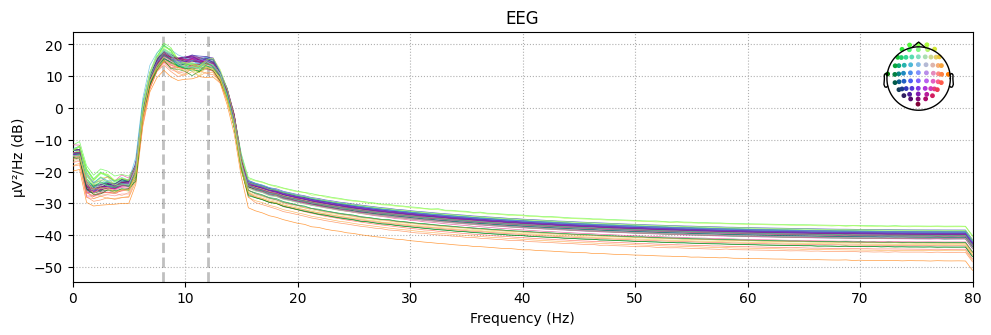

In [7]:
raw_open.compute_psd().plot()
plt.show()

Effective window size : 1.600 (s)


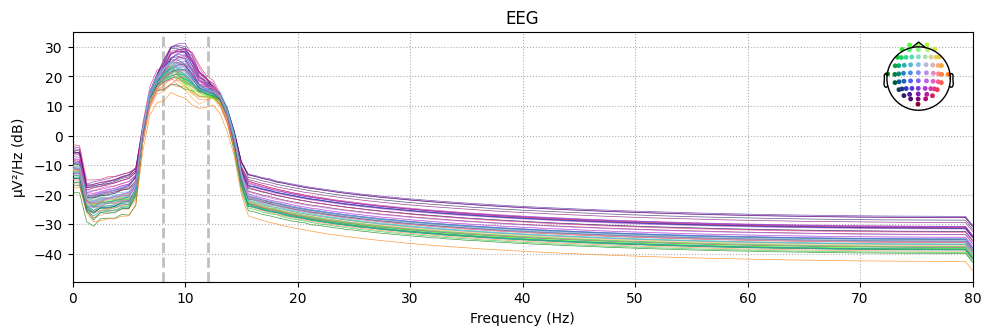

In [8]:
raw_closed.compute_psd().plot()
plt.show()

In [9]:
cov_open = get_cov(raw_open)
cov_closed = get_cov(raw_closed)
#compute_inverse = make_fast_inverse_operator(raw_open.info, fwd, cov, snr=snr)

In [10]:
verbose = False
method = "eLORETA"
nave = 1
lambda2 = 1/snr**2
inv_open = mne.minimum_norm.make_inverse_operator(info, fwd, cov_open, verbose=verbose)
inv_open = mne.minimum_norm.prepare_inverse_operator(inv_open, nave, lambda2, method=method, verbose=verbose)

inv_closed = mne.minimum_norm.make_inverse_operator(info, fwd, cov_closed, verbose=verbose)
inv_closed = mne.minimum_norm.prepare_inverse_operator(inv_closed, nave, lambda2, method=method, verbose=verbose)

In [11]:
stc_open = mne.minimum_norm.apply_inverse_raw(raw_open, inv_open, lambda2, method=method, nave=nave, prepared=True, verbose=False)
stc_closed = mne.minimum_norm.apply_inverse_raw(raw_closed, inv_closed, lambda2, method=method, nave=nave, prepared=True, verbose=False)

In [12]:
activity_open = get_power_per_label(stc_open, labels, standardize=False)
activity_closed = get_power_per_label(stc_closed, labels, standardize=False)

(9633,)

In [27]:
psd_open.shape

(100, 129)

Effective window size : 1.600 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


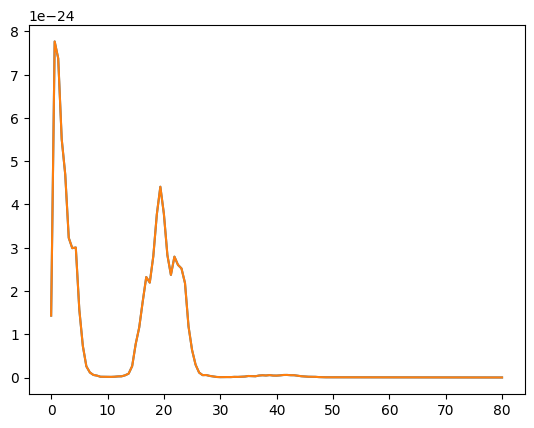

In [32]:
psd_open, freqs_open = mne.time_frequency.psd_array_welch(stc_open.data[0], sfreq=sfreq)
plt.plot(freqs_open, psd_open)
plt.show()

#psd_closed, freqs_closed = mne.time_frequency.psd_array_welch(stc_closed.data[100], sfreq=sfreq)
#plt.plot(freqs_closed, psd_closed)
#plt.show()

In [26]:
cov = mne.compute_raw_covariance(raw_open, method='empirical')
inv = mne.minimum_norm.make_inverse_operator(info, fwd, cov, verbose=verbose)
stc = mne.minimum_norm.apply_inverse_raw(raw_open, inv, lambda2, method=method, nave=nave, verbose=False)

Using up to 301 segments
Number of samples used : 9632
[done]


In [31]:
np.all(stc.data == stc_open.data)

True

In [13]:
occi_open = np.mean([activity_open[hemi][i] for hemi in range(2) for i, label in enumerate(labels[hemi]) if 'occipital' in label.name])
occi_closed = np.mean([activity_closed[hemi][i] for hemi in range(2) for i, label in enumerate(labels[hemi]) if 'occipital' in label.name])

In [23]:
tmp_open = np.load('mmidb_aparc.a2009s_1.0_8.0_12.0_parallel.npy', allow_pickle=True).item()[patient][f'{patient}R01']['T0']
tmp_closed = np.load('mmidb_aparc.a2009s_1.0_8.0_12.0_parallel.npy', allow_pickle=True).item()[patient][f'{patient}R02']['T0']

In [ ]:
color = np.mean(stc_closed.data, axis=1)
# Standardize color between 0 and 1
color = (color - np.min(color)) / (np.max(color) - np.min(color))
color = color.reshape(2, 10242)
#tris_values = vertex_values_to_tris_values(color, tris_sources, func=np.max)

In [ ]:
activity_open = get_power_per_label(stc_open, labels, standardize=False)
values = activity_to_source_values(activity_open, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

In [120]:
activity = [[None]*len(labels[0]), [None]*len(labels[1])]

In [121]:
for hemi in range(2):
    for i, label in enumerate(labels[hemi]):
        if 'occipital' in label.name:
            activity[hemi][i] = 1
        else:
            activity[hemi][i] = 0

In [122]:
values = activity_to_source_values(activity, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

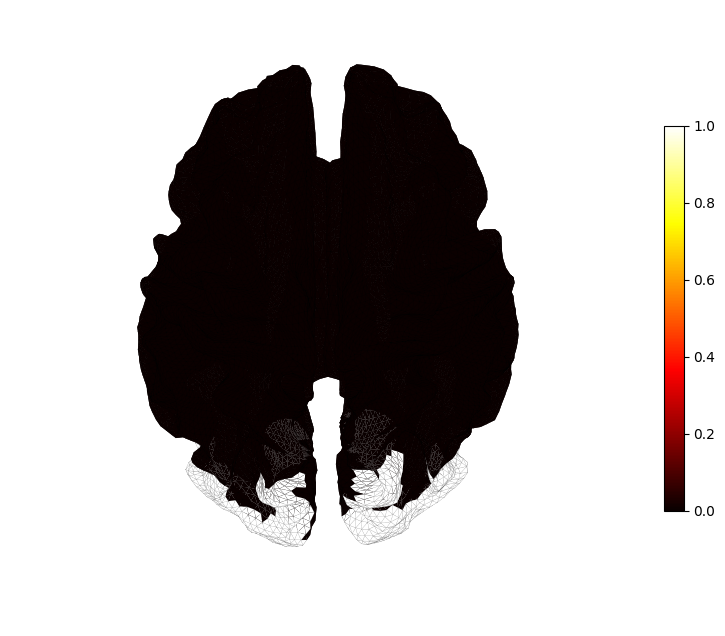

In [141]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

lh_mesh.set_array(tris_values[0])
#fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, -90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout()
plt.show()